<a href="https://colab.research.google.com/github/Niccolo-Rocchi/Medical_Imaging_project/blob/main/U_net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Semantic Segmentation on Pneuomothorax dataset


---


Task: Binary Mask Prediction (Pneuomothorax Area) 

Pneuomothorax Challenge: https://siim.org/page/pneumothorax_challenge

*Authors: Pirola Federico, Rocchi Niccolò*

*Università degli studi di Milano-Bicocca, Milan, Italy*

# U-net segmentation

## Imports

In [ ]:
%%capture 
!pip install pydicom

In [ ]:
# For reading files
from pydicom import dcmread 
import glob
from google.colab import drive
# For dealing with data
import numpy as np
import pandas as pd
import re
import random
random.seed(123)
import os
# For plots
import matplotlib.pyplot as plt
from skimage.io import imread, imshow
# For nets
import tensorflow as tf
from skimage.transform import resize
from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers import Concatenate as concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam
from keras.losses import binary_crossentropy

In [ ]:
# Mount Drive data
drive.mount('/content/drive/')
%cd /content/drive/MyDrive/pneumotorax_data

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/MyDrive/DS Lab in Medicine - projects/Medical Imaging - project/pneumotorax_data


## Data upload


In [ ]:
# Data upload from `Data_Preprocesing` notebook
train_set = pd.read_csv("train_set.csv")
val_set = pd.read_csv("val_set.csv")

## Data Generator for the net

In [ ]:
# RLE to mask conversion provided by competition organizers with the dataset.
def rle2mask(rle, width, height):
    mask= np.zeros(width*height)

    if rle != ' -1':
      array = np.asarray([int(x) for x in rle.split()])
      starts = array[0::2]
      lengths = array[1::2]

      current_position = 0
      for index, start in enumerate(starts):
          current_position += start
          mask[current_position:current_position+lengths[index]] = 1
          current_position += lengths[index]

    return mask.reshape(width, height, order='F')

In [ ]:
# Create input for Keras' fit function
class DataGenerator:

  # Method that yields (image, mask) tuple
  def data_generator(self, data):
    while True:
      i = 0
      while i < len(data):
        # Extract ID and its encoded pixels
        id, rle = data[["ImageId"," EncodedPixels"]].iloc[i]
        # Convert encoded pixels to mask
        mask = rle2mask(rle, 1024, 1024)
        # Read the image associate to ImageId
        try:
          dcm_file = dcmread(f"./dicom_files/{id}.dcm")
        except:
          continue
        dcm_image = dcm_file.pixel_array
        # Rescale image
        image = dcm_image/255
        # Expand dimensions
        image = np.expand_dims(image, axis=-1)
        mask = np.expand_dims(mask, axis=-1)
        # Resize image and mask
        mask = tf.keras.layers.Resizing(256, 256, interpolation="nearest", crop_to_aspect_ratio=False)(mask)
        image = tf.keras.layers.Resizing(256, 256, interpolation="bilinear", crop_to_aspect_ratio=False)(image)
        # Mask to categorical
        mask = tf.keras.utils.to_categorical(mask, num_classes = 2)
        yield (image, mask)
        i += 1

  # Create train generator for net input
  def train_generator(self, batch_size):
    # Create a tensorflow iterator
    tf_iterator = tf.data.Dataset.from_generator(lambda: self.data_generator(train_set), output_types=(tf.float64, tf.float64))
    # Create batch size
    tf_iterator = tf_iterator.batch(batch_size)
    # Return generator
    return tf_iterator

  # Create validation generator for net input
  def val_generator(self, batch_size):
    # Create a tensorflow iterator
    tf_iterator = tf.data.Dataset.from_generator(lambda: self.data_generator(val_set), output_types=(tf.float64, tf.float64))
    # Create batch size
    tf_iterator = tf_iterator.batch(batch_size)
    # Return generator
    return tf_iterator

## U-net

### Metrics

In [ ]:
# Intersection-Over-Union (IoU), also known as the Jaccard Index
def IoU(y_true, y_pred):
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3]) - K.sum(y_true * y_pred, axis=[1,2,3])
    return intersection / union

# True Positive Rate
def true_positive_rate(y_true, y_pred):
    return K.sum(K.flatten(y_true)*K.flatten(K.round(y_pred)))/K.sum(y_true)

# Dice coefficient
def dice_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    sum = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
    return K.mean( (2. * intersection + smooth) / (sum + smooth), axis=0)

### Loss functions

In [ ]:
# Focal loss
def focal_loss(gamma=2., alpha=.25):
	def focal_loss_fixed(y_true, y_pred):
		pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
		pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
		return -K.mean(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1+K.epsilon())) - K.mean((1 - alpha) * K.pow(pt_0, gamma) * K.log(1. - pt_0 + K.epsilon()))
	return focal_loss_fixed

# Dice loss
def dice_loss(y_true, y_pred, smooth=1):
    return 1 - dice_coef(y_true, y_pred)

# BinaryCrossEntropy

### Net definition and train


In [ ]:
# Metrics
metrics = [dice_coef, true_positive_rate, IoU]

# Loss
loss = focal_loss()

# Batch and epochs
batch_size = 32
epochs = 20
assert(batch_size <= 32)

# Callbacks
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3) 

In [ ]:
# Net
def create_model(loss):

  # Model description
  inputs = Input((256, 256, 1))

  c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (inputs)
  c1 = Dropout(0.1) (c1)
  c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
  p1 = MaxPooling2D((2, 2)) (c1)

  c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
  c2 = Dropout(0.1) (c2)
  c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
  p2 = MaxPooling2D((2, 2)) (c2)

  c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
  c3 = Dropout(0.2) (c3)
  c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
  p3 = MaxPooling2D((2, 2)) (c3)

  c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
  c4 = Dropout(0.2) (c4)
  c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
  p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

  c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
  c5 = Dropout(0.3) (c5)
  c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

  u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
  u6 = concatenate()([u6, c4])
  c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
  c6 = Dropout(0.2) (c6)
  c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

  u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
  u7 = concatenate()([u7, c3])
  c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
  c7 = Dropout(0.2) (c7)
  c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

  u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
  u8 = concatenate()([u8, c2])
  c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
  c8 = Dropout(0.1) (c8)
  c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

  u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
  u9 = concatenate(axis=3)([u9, c1])
  c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
  c9 = Dropout(0.1) (c9)
  c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

  outputs = Conv2D(2, (1, 1), activation='sigmoid') (c9)

  model = Model(inputs=[inputs], outputs=[outputs])

  # Model compilation
  model.compile(optimizer='adam', loss = loss, metrics = metrics)

  # Return model
  return model

In [ ]:
# Net input generator
train_generator = DataGenerator().train_generator(batch_size)
val_generator = DataGenerator().val_generator(batch_size)

In [ ]:
# Create model
model = create_model(loss)

# Fit model
model_history = model.fit(x = train_generator, 
                          epochs = epochs, 
                          steps_per_epoch=(len(train_set)//batch_size),
                          validation_data = val_generator,
                          validation_steps = (len(val_set)//batch_size),
                          callbacks = callback, 
                          )

Epoch 1/20
164/164 [==============================] - 2013s 12s/step - loss: 0.0087 - dice_coef: 0.8794 - true_positive_rate: 0.9864 - IoU: 0.4397 - val_loss: 0.0040 - val_dice_coef: 0.8937 - val_true_positive_rate: 0.9950 - val_IoU: 0.4468
Epoch 2/20
164/164 [==============================] - 281s 2s/step - loss: 0.0041 - dice_coef: 0.8928 - true_positive_rate: 0.9945 - IoU: 0.4464 - val_loss: 0.0037 - val_dice_coef: 0.8932 - val_true_positive_rate: 0.9950 - val_IoU: 0.4466
Epoch 3/20
164/164 [==============================] - 288s 2s/step - loss: 0.0038 - dice_coef: 0.8971 - true_positive_rate: 0.9944 - IoU: 0.4486 - val_loss: 0.0036 - val_dice_coef: 0.8938 - val_true_positive_rate: 0.9949 - val_IoU: 0.4469
Epoch 4/20
164/164 [==============================] - 312s 2s/step - loss: 0.0036 - dice_coef: 0.9029 - true_positive_rate: 0.9944 - IoU: 0.4515 - val_loss: 0.0034 - val_dice_coef: 0.9060 - val_true_positive_rate: 0.9949 - val_IoU: 0.4530
Epoch 5/20
164/164 [======================

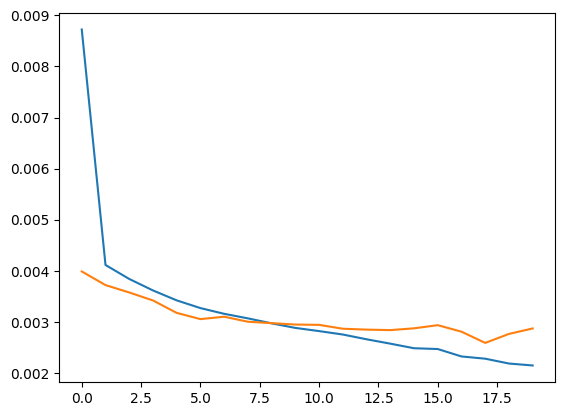

In [ ]:
# Plot losses
train_loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

plt.plot(train_loss)
plt.plot(val_loss)

In [ ]:
# Save the weights
model.save_weights(f'./trained_models/focal_loss_model/focal_loss')

In [ ]:
# Create a new model instance
new_model = create_model(loss)

# Restore the weights
new_model.load_weights(f'./trained_models/focal_loss_model/focal_loss')

In [ ]:
pd.DataFrame(model_history.history).to_csv(f'./trained_models_history/focal_loss')

In [ ]:
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  #pred_mask = pred_mask[..., tf.newaxis]
  return np.array(pred_mask[0], dtype = 'float32')

## Mask Prediction Example

In [ ]:
# Loss
loss_3 = focal_loss()

# Create model
focal_model = create_model(loss_3)

# Restore the weights
focal_model.load_weights(f'./trained_models/focal_loss_model/focal_loss')

history_focal = pd.read_csv('./trained_models_history/focal_loss')

In [ ]:
encoded_pixels = pd.read_csv("encoded_pixels.csv")

In [ ]:
# Patient
idx = "1.2.276.0.7230010.3.1.4.8323329.32579.1517875161.299312"

# Image
dcmHead = dcmread("./dicom_files/" + idx + ".dcm")
true_img = dcmHead.pixel_array / 255
true_img = np.expand_dims(true_img, axis=-1)
true_img = tf.keras.layers.Resizing(256, 256, interpolation="bilinear", crop_to_aspect_ratio=False)(true_img)

# True mask
true_mask = encoded_pixels.iloc[4][" EncodedPixels"]
true_mask = rle2mask(true_mask, 1024, 1024)
true_mask = np.expand_dims(true_mask, axis=-1)
true_mask = tf.keras.layers.Resizing(256, 256, interpolation="nearest", crop_to_aspect_ratio=False)(true_mask)

1/1 [==============================] - 1s 501ms/step


(-0.5, 149.5, 149.5, -0.5)

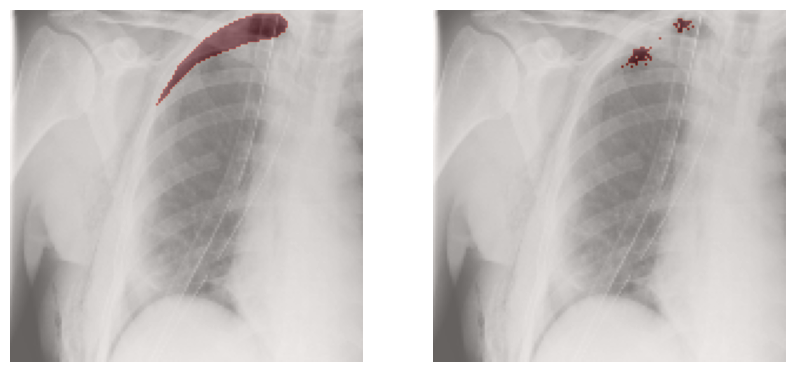

In [ ]:
plt.figure(figsize=(10, 5))

# True
plt.subplot(121)
img = np.array(true_img[:150, :150, 0])
mask = np.array(true_mask[:150, :150, 0])
#mask[mask<0.5]=np.nan

plt.imshow(img, cmap='gray')
plt.imshow(mask, alpha=0.4,cmap='Reds',vmin=0,vmax=1)
plt.axis('off')

# Predicted
plt.subplot(122)
pred_mask = focal_model.predict(np.expand_dims(true_img, axis=0))
pred_mask = create_mask(pred_mask)
# pred_mask[pred_mask<0.5] = np.nan

plt.imshow(img, cmap='gray')
plt.imshow(pred_mask[:150, :150], alpha=0.4,cmap='Reds', vmin=0, vmax=1)
plt.axis('off')
